# Weather dataset drift localisation with different classifiers - yearly predictions

In [3]:
import numpy as np
import pandas as pd
from scipy.io import arff
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import math

from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)



from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

## Accept and preprocess the weather dataset

In [4]:
df = pd.read_csv("real_world_data/weather_dataset.csv")

print(df.head())

X = df.drop(columns=['Unnamed: 0', 'Label_Rain'])
y = df["Label_Rain"]

print(X.head())
print(y.head())

X_ref = X[:6053]
X_test = X[6053:]
y_ref = y[:6053]
y_test = y[6053:]

# X_ref, X_test, y_ref, y_test = train_test_split(X, y, train_size=0.30, shuffle=False)

X_ref = X_ref.to_numpy()
X_test = X_test.to_numpy()
y_ref = y_ref.to_numpy()
y_test = y_test.to_numpy()

# scale the data - consistency measure: it will also be scaled for drift detection later
scaler = MinMaxScaler()
scaler.fit(X_ref)
X_ref = scaler.transform(X_ref)
X_test = scaler.transform(X_test)

print('\nreference data')
print(X_ref.shape)
print(X_ref)
print('\nreference labels')
print(y_ref.shape)
print('\ntesting data')
print(X_test.shape)
print(X_test)
print('\ntesting labels')
print(y_test.shape)

   Unnamed: 0  TEMP  DEWP     SLP  VISIB  WDSP  MXSPD   MAX   MIN  Label_Rain
0           0  24.7  21.3  1013.8    1.8   8.9   12.0  30.9  19.9           1
1           1  26.6  20.1  1015.7    5.5  11.9   18.1  30.0  19.0           1
2           2  24.0  16.5  1018.6    9.3   8.0   14.0  28.9  19.0           0
3           3  24.9  17.2  1014.2   10.6   6.7   22.0  39.9  17.1           0
4           4  21.9  12.3  1017.5    9.8  10.5   28.9  34.0  15.1           0
   TEMP  DEWP     SLP  VISIB  WDSP  MXSPD   MAX   MIN
0  24.7  21.3  1013.8    1.8   8.9   12.0  30.9  19.9
1  26.6  20.1  1015.7    5.5  11.9   18.1  30.0  19.0
2  24.0  16.5  1018.6    9.3   8.0   14.0  28.9  19.0
3  24.9  17.2  1014.2   10.6   6.7   22.0  39.9  17.1
4  21.9  12.3  1017.5    9.8  10.5   28.9  34.0  15.1
0    1
1    1
2    0
3    0
4    0
Name: Label_Rain, dtype: int64

reference data
(6053, 8)
[[0.32335329 0.45853659 0.50909091 ... 0.21443737 0.00335913 0.36567926]
 [0.34231537 0.44682927 0.53787879 ... 0.34

## Define helper functions

In [5]:
import random


def take_out_random_batch(X, y, batch_size, random_state):
    """Take a random batch of data out of the reference data"""
    random.seed(a=random_state)
    start = random.randint(0, X.shape[0] - batch_size)
    indices = list(range(start, start + batch_size))
    
    X_extracted_batch = X[indices]
    X_rest = np.delete(X, indices, axis=0)
    y_extracted_batch = y[indices]
    y_rest = np.delete(y, indices, axis=0)
    
#     print('shape of points in the extracted batch')
#     print(X_extracted_batch.shape)
#     print('shape of points in the rest')
#     print(X_rest.shape)
    
    return X_extracted_batch, X_rest, y_extracted_batch, y_rest


def find_model_expected_accuracy(X, y, batch_size, model, min_runs=10, std_err_threshold=0.05):
    print('model', model)
    accuracies = []
    accuracy_std_err = 100
    current_random_state = 0
    i = 0
    while i < min_runs or accuracy_std_err > std_err_threshold:
        X_extracted_batch, X_rest, y_extracted_batch, y_rest = take_out_random_batch(
            X_ref, y_ref, batch_size, random_state=current_random_state)
        y_pred = model.fit(X_rest, y_rest).predict(X_extracted_batch)
        accuracies.append(accuracy_score(y_extracted_batch, y_pred))
        if len(accuracies) > 1:
            accuracy_std_err = np.std(accuracies) / np.sqrt(len(accuracies))
        current_random_state += 1
        i += 1
    
    return np.mean(accuracies), np.std(accuracies)

## Define parameter values

In [6]:
random_state = 42
batch_size = 365  # yearly predictions

## Find the model with the highest accuracy

In [6]:
model_names = ["GaussianNB", "DecisionTreeClassifier", "KNeighborsClassifier", "SVM", "LogisticRegression"]
model_final_accuracies = {
    "GaussianNB": 0.0,
    "DecisionTreeClassifier": 0.0,
    "KNeighborsClassifier": 0.0,
    "SVM": 0.0,
    "LogisticRegression": 0.0
}

### Try GaussianNB

In [7]:
gnb = GaussianNB()

print(model_final_accuracies)
model_final_accuracies["GaussianNB"], _ = find_model_expected_accuracy(X_ref, y_ref, batch_size, model=gnb)
print(model_final_accuracies)

{'GaussianNB': 0.0, 'DecisionTreeClassifier': 0.0, 'KNeighborsClassifier': 0.0, 'SVM': 0.0, 'LogisticRegression': 0.0}
model GaussianNB()
{'GaussianNB': 0.6947945205479451, 'DecisionTreeClassifier': 0.0, 'KNeighborsClassifier': 0.0, 'SVM': 0.0, 'LogisticRegression': 0.0}


### Hyperparameter tuning imports

In [8]:
import skopt
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

### Try decision trees

In [9]:
model = DecisionTreeClassifier(random_state=random_state) # best accuracy = 0.7334

space  = [Categorical(['gini', 'entropy'], name='criterion'), # best = 'entropy'
         Categorical(['best', 'random'], name='splitter'), # best = 'random'
         Integer(1, 100, name='max_depth')] # best = 8

@use_named_args(space)
def objective(**params):
    model.set_params(**params)
    return (1 - (find_model_expected_accuracy(X_ref, y_ref, batch_size, model=model))[0])

res_gp = gp_minimize(objective, space, n_calls=100, random_state=random_state)

print("Best accuracy=%.4f" % (1 - res_gp.fun))
print("""Best parameters:""", res_gp.x)
plot_convergence(res_gp)
model_final_accuracies["DecisionTreeClassifier"] = (1 - res_gp.fun)

model DecisionTreeClassifier(max_depth=78, random_state=42)
model DecisionTreeClassifier(max_depth=11, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=15, random_state=42)
model DecisionTreeClassifier(max_depth=72, random_state=42)
model DecisionTreeClassifier(max_depth=99, random_state=42)
model DecisionTreeClassifier(max_depth=2, random_state=42, splitter='random')
model DecisionTreeClassifier(criterion='entropy', max_depth=41, random_state=42,
                       splitter='random')
model DecisionTreeClassifier(criterion='entropy', max_depth=24, random_state=42,
                       splitter='random')
model DecisionTreeClassifier(criterion='entropy', max_depth=39, random_state=42,
                       splitter='random')
model DecisionTreeClassifier(max_depth=86, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=42)
model DecisionTreeClassifier(max_depth=22, random_state=42)
model DecisionTreeClassifier(max

C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=100, random_state=42)
model DecisionTreeClassifier(max_depth=6, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=68, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=74, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=94, random_state=42)
model DecisionTreeClassifier(max_depth=5, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=44, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=70, random_state=42,
                       splitter='random')
model DecisionTreeClassifier(max_depth=1, random_state=42, splitter='random')
model DecisionTreeClassifier(criterion='entropy', max_depth=53, random_state=42)
model DecisionTreeClassifier(max_depth=7, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(max_depth=7, random_state=42)
model DecisionTreeClassifier(max_depth=8, random_state=42)
model DecisionTreeClassifier(max_depth=47, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(max_depth=7, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=42,
                       splitter='random')
model DecisionTreeClassifier(criterion='entropy', max_depth=36, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(max_depth=7, random_state=42)
model DecisionTreeClassifier(max_depth=83, random_state=42, splitter='random')
model DecisionTreeClassifier(max_depth=59, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=7, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)
model DecisionTreeClassifier(max_depth=33, random_state=42)
model DecisionTreeClassifier(max_depth=15, random_state=42, splitter='random')
model DecisionTreeClassifier(max_depth=31, random_state=42, splitter='random')


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=9, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=85, random_state=42,
                       splitter='random')


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=9, random_state=42)
model DecisionTreeClassifier(max_depth=63, random_state=42, splitter='random')
model DecisionTreeClassifier(criterion='entropy', max_depth=87, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=12, random_state=42,
                       splitter='random')
model DecisionTreeClassifier(criterion='entropy', max_depth=55, random_state=42,
                       splitter='random')


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)
model DecisionTreeClassifier(max_depth=92, random_state=42, splitter='random')
model DecisionTreeClassifier(max_depth=74, random_state=42, splitter='random')


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=17, random_state=42,
                       splitter='random')


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)
model DecisionTreeClassifier(max_depth=44, random_state=42, splitter='random')


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)
model DecisionTreeClassifier(max_depth=40, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=9, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=42,
                       splitter='random')
model DecisionTreeClassifier(criterion='entropy', max_depth=9, random_state=42,
                       splitter='random')


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=9, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=9, random_state=42)
model DecisionTreeClassifier(max_depth=9, random_state=42, splitter='random')
model DecisionTreeClassifier(max_depth=7, random_state=42, splitter='random')
model DecisionTreeClassifier(criterion='entropy', max_depth=7, random_state=42,
                       splitter='random')
model DecisionTreeClassifier(max_depth=11, random_state=42, splitter='random')
model DecisionTreeClassifier(criterion='entropy', max_depth=12, random_state=42)
model DecisionTreeClassifier(max_depth=10, random_state=42, splitter='random')
model DecisionTreeClassifier(criterion='entropy', max_depth=90, random_state=42)
model DecisionTreeClassifier(max_depth=65, random_state=42)
model DecisionTreeClassifier(max_depth=23, random_state=42, splitter='random')


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=42,
                       splitter='random')
model DecisionTreeClassifier(criterion='entropy', max_depth=32, random_state=42,
                       splitter='random')


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=42,
                       splitter='random')
model DecisionTreeClassifier(criterion='entropy', max_depth=62, random_state=42,
                       splitter='random')
model DecisionTreeClassifier(criterion='entropy', max_depth=78, random_state=42,
                       splitter='random')


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=9, random_state=42)


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


model DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=49, random_state=42)
model DecisionTreeClassifier(criterion='entropy', max_depth=48, random_state=42,
                       splitter='random')
model DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=42,
                       splitter='random')


C:\Users\jpohl\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


KeyboardInterrupt: 

### Try k nearest neighbors

In [ ]:
model = KNeighborsClassifier() # best accuracy = 0.7627

space  = [Integer(1, 100, name='n_neighbors')] # best = 21

@use_named_args(space)
def objective(**params):
    model.set_params(**params)
    return (1 - (find_model_expected_accuracy(X_ref, y_ref, batch_size, model=model))[0])

res_gp = gp_minimize(objective, space, n_calls=100, random_state=random_state)

print("Best accuracy=%.4f" % (1 - res_gp.fun))
print("""Best parameters:""", res_gp.x)
plot_convergence(res_gp)
model_final_accuracies["KNeighborsClassifier"] = (1 - res_gp.fun)

### Try SVM

In [ ]:
model = SVC(random_state=random_state) # best accuracy = 0.7926

space  = [Real(0.1, 20, name='C')] # best = 11.98

@use_named_args(space)
def objective(**params):
    model.set_params(**params)
    return (1 - (find_model_expected_accuracy(X_ref, y_ref, batch_size, model=model))[0])

res_gp = gp_minimize(objective, space, n_calls=10, random_state=random_state)

print("Best accuracy=%.4f" % (1 - res_gp.fun))
print("""Best parameters:""", res_gp.x)
plot_convergence(res_gp)
model_final_accuracies["SVM"] = (1 - res_gp.fun)

### Try logistic regression

In [ ]:
model = LogisticRegression(random_state=random_state, max_iter=10000) # best accuracy = 0.7723

space  = [Real(0.1, 20, name='C')] # best = 9.03

@use_named_args(space)
def objective(**params):
    model.set_params(**params)
    return (1 - (find_model_expected_accuracy(X_ref, y_ref, batch_size, model=model))[0])

res_gp = gp_minimize(objective, space, n_calls=100, random_state=random_state)

print("Best accuracy=%.4f" % (1 - res_gp.fun))
print("""Best parameters:""", res_gp.x)
plot_convergence(res_gp)
model_final_accuracies["LogisticRegression"] = (1 - res_gp.fun)

## Use the best model to define drifting batches

### Find the best model through accuracies

In [6]:
print('best obtained model accuracies:')
print(model_final_accuracies)

best obtained model accuracies:


NameError: name 'model_final_accuracies' is not defined

### Define the model with the best parameters (hardcoded in the cells above), get its accuracy information

In [7]:
best_model = SVC(random_state=random_state, C=11.98)
expected_accuracy, expected_standard_deviation = find_model_expected_accuracy(X_ref, y_ref, batch_size, model=best_model)
print('expected accuracy:', expected_accuracy)
print('expected standard deviation:', expected_standard_deviation)

model SVC(C=11.98, random_state=42)
expected accuracy: 0.7926027397260275
expected standard deviation: 0.022494135096006597


### Fit the model on all reference data

In [8]:
best_model_fitted = SVC(random_state=random_state, C=11.98).fit(X_ref, y_ref)

### Split testing data to batches

In [9]:
def split_to_fixed_size_batches(X, y, batch_size):
    """Split X and y to batches of the given batch_size"""
    chunk_size = batch_size
    print('chunk size', chunk_size)

    num_chunks = (X.shape[0] - (X.shape[0] % chunk_size)) // chunk_size
    print('number of chunks', num_chunks)
    print('number of data', X.shape[0])
    X_perfect_size = X[:-(X.shape[0] % chunk_size), :]
    y_perfect_size = y[:-(y.shape[0] % chunk_size)]
    print('shape of X that can be split perfectly', X_perfect_size.shape)
    X_batches = np.array_split(X_perfect_size, num_chunks)
    y_batches = np.array_split(y_perfect_size, num_chunks)

    print('number of resulting batches', len(X_batches))
    print(X_batches[0])
    print(X_batches[0].shape)
    
    return X_batches, y_batches


X_test_batches, y_test_batches = split_to_fixed_size_batches(X_test, y_test, batch_size=batch_size)

chunk size 365
number of chunks 33
number of data 12106
shape of X that can be split perfectly (12045, 8)
number of resulting batches 33
[[0.80538922 0.84       0.57272727 ... 0.16985138 0.00855777 0.7854954 ]
 [0.82035928 0.85853659 0.56060606 ... 0.14861996 0.00936756 0.7854954 ]
 [0.88922156 0.87804878 0.49242424 ... 0.1910828  0.00965749 0.86823289]
 ...
 [0.78043912 0.83804878 0.61969697 ... 0.14861996 0.00814788 0.80183861]
 [0.77844311 0.87219512 0.61363636 ... 0.19532909 0.00850779 0.80183861]
 [0.81736527 0.88780488 0.58333333 ... 0.492569   0.00868774 0.82022472]]
(365, 8)


### Find test batch accuracies

In [10]:
accs = []
for batch in range(len(X_test_batches)):
    accs.append(accuracy_score(y_test_batches[batch], best_model.predict(X_test_batches[batch])))
    
print('\nTEST BATCH ACCURACIES')
print(accs)


TEST BATCH ACCURACIES
[0.7780821917808219, 0.7671232876712328, 0.7534246575342466, 0.7506849315068493, 0.8027397260273973, 0.726027397260274, 0.8465753424657534, 0.7945205479452054, 0.8164383561643835, 0.863013698630137, 0.7698630136986301, 0.7643835616438356, 0.7863013698630137, 0.7753424657534247, 0.6821917808219178, 0.7534246575342466, 0.7534246575342466, 0.7068493150684931, 0.7835616438356164, 0.7945205479452054, 0.7780821917808219, 0.7616438356164383, 0.7863013698630137, 0.7534246575342466, 0.7698630136986301, 0.7808219178082192, 0.7424657534246575, 0.7589041095890411, 0.7671232876712328, 0.7753424657534247, 0.863013698630137, 0.7534246575342466, 0.7616438356164383]


### Show drifting batches visually (below red line = drift)

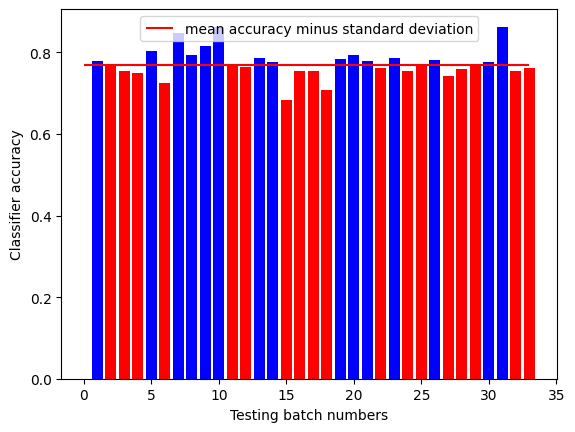

In [15]:
total_num_batches = len(X_test_batches)
colors = ['red' if acc < expected_accuracy - expected_standard_deviation else 'blue' for acc in accs]
barlist = plt.bar(range(1, total_num_batches + 1), accs, color=colors)
plt.hlines(y=expected_accuracy - expected_standard_deviation, xmin=0, xmax=total_num_batches,
           color='red', label='mean accuracy minus standard deviation')
plt.legend(loc='upper center')
plt.xlabel('Testing batch numbers')
plt.ylabel('Classifier accuracy')
plt.show()

### Define drifting batches

In [12]:
# define the batches with and without drift (same as the plot above)

drift_boolean_mask = [True if acc < expected_accuracy - expected_standard_deviation else False for acc in accs]
print('Drift in first 10 batches')
print(drift_boolean_mask[:10])

Drift in first 10 batches
[False, True, True, True, False, True, False, False, False, False]


In [13]:
result_dict = {
    'expected_accuracy': expected_accuracy,
    'standard_deviation': expected_standard_deviation,
    'accs': accs,
    'defined_drifts': drift_boolean_mask
}

np.save('weather_year_drift_def.npy', result_dict)

### Store the result in a file

In [20]:
import csv
with open('weather_yearly_drifts.csv', 'w') as f:
    wrtr = csv.writer(f)
    wrtr.writerow(drift_boolean_mask)